# Noise Reduction

Dataset Used- [Noisy speech database for training speech enhancement algorithms and TTS models](https://datashare.ed.ac.uk/handle/10283/1942).

Contains *.wav* files with noisy speech and clean speech.

A subset of the files is used here to test if the approach is working or not

## Importing libraries

In [13]:
import os
import glob
import time
import random
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import soundfile as sf  # to save denoised output as wav file


## Defining parameters

In [14]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Parameters for audio processing
SR = 22050                # Sampling rate (Hz)
DURATION = 3              # Duration in seconds to load from each file
FIXED_LENGTH = SR * DURATION  # Number of samples per audio file
N_MELS = 128              # Number of Mel bands for spectrogram
HOP_LENGTH = 512          # Hop length for the STFT computation
# TIME_FRAMES = int(np.ceil(FIXED_LENGTH / HOP_LENGTH))  # Approximate time frames
TIME_FRAMES = 128  # Approximate time frames
# For PyTorch, input shape will be (channels, n_mels, time_frames)
INPUT_SHAPE = (1, N_MELS, TIME_FRAMES)  

# Directories for data (change these paths as needed; expecting WAV files now)
clean_dir = 'D:/projects/sound_ML/data/clean_testset_wav'   # Directory containing clean WAV files
noisy_dir = 'D:/projects/sound_ML/data/noisy_testset_wav'   # Directory containing noisy WAV files


## Creating helper functions for reusibility

In [15]:
def load_audio(file_path, sr=SR, duration=DURATION):
    """
    Load an audio file and pad or truncate it to FIXED_LENGTH samples.
    """
    try:
        y, _ = librosa.load(file_path, sr=sr, duration=duration)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None
    if len(y) < FIXED_LENGTH:
        y = np.pad(y, (0, FIXED_LENGTH - len(y)), mode='constant')
    else:
        y = y[:FIXED_LENGTH]
    return y

def compute_mel_spectrogram(y, sr=SR, n_mels=N_MELS, hop_length=HOP_LENGTH):
    """
    Compute a Mel-spectrogram from an audio signal and convert it to a normalized log scale.
    """
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    S_db = librosa.power_to_db(S, ref=np.max)  # Convert to dB scale
    # Normalize to [0,1] assuming dB values in [-80, 0]
    S_norm = (S_db + 80) / 80  
    return S_norm

def preprocess_file(file_path):
    y = load_audio(file_path)
    if y is None:
        return None
    mel_spec = compute_mel_spectrogram(y)
    # Crop or pad to TIME_FRAMES = 128
    if mel_spec.shape[1] < TIME_FRAMES:
        pad_width = TIME_FRAMES - mel_spec.shape[1]
        mel_spec = np.pad(mel_spec, ((0,0), (0, pad_width)), mode='constant')
    else:
        mel_spec = mel_spec[:, :TIME_FRAMES]
    mel_spec = np.expand_dims(mel_spec, axis=0)  # Shape: (1, n_mels, TIME_FRAMES)
    return mel_spec


In [16]:
def visualize_waveform(y, sr=SR, title="Waveform"):
    plt.figure(figsize=(10, 3))
    librosa.display.waveshow(y, sr=sr)
    plt.title(title)
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()

def visualize_spectrogram(S, sr=SR, hop_length=HOP_LENGTH, title="Spectrogram"):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

## Preprocessing files

Found 824 clean files and 824 noisy files.
Using 824 paired files for training.
File 1 preprocessed successfully.
File 2 preprocessed successfully.
File 3 preprocessed successfully.
File 4 preprocessed successfully.
File 5 preprocessed successfully.
File 6 preprocessed successfully.
File 7 preprocessed successfully.
File 8 preprocessed successfully.
File 9 preprocessed successfully.
File 10 preprocessed successfully.
File 11 preprocessed successfully.
File 12 preprocessed successfully.
File 13 preprocessed successfully.
File 14 preprocessed successfully.
File 15 preprocessed successfully.
File 16 preprocessed successfully.
File 17 preprocessed successfully.
File 18 preprocessed successfully.
File 19 preprocessed successfully.
File 20 preprocessed successfully.
File 21 preprocessed successfully.
File 22 preprocessed successfully.
File 23 preprocessed successfully.
File 24 preprocessed successfully.
File 25 preprocessed successfully.
File 26 preprocessed successfully.
File 27 preprocesse

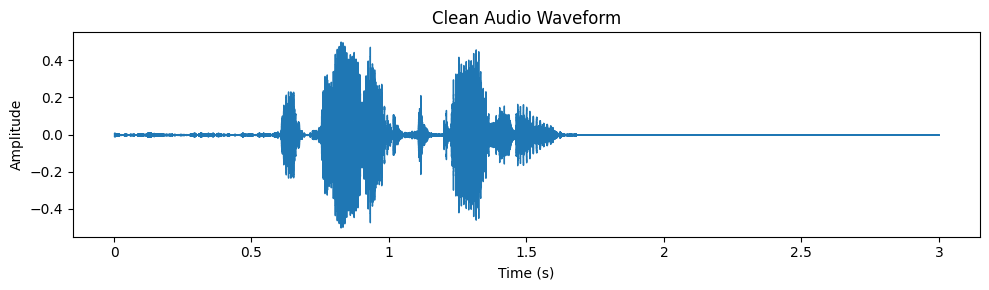

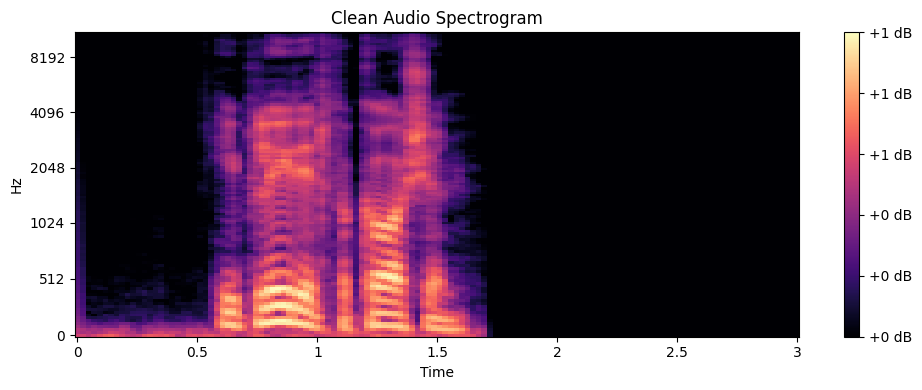

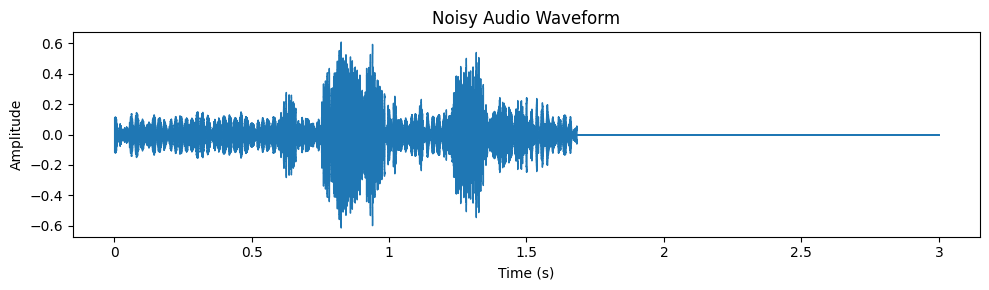

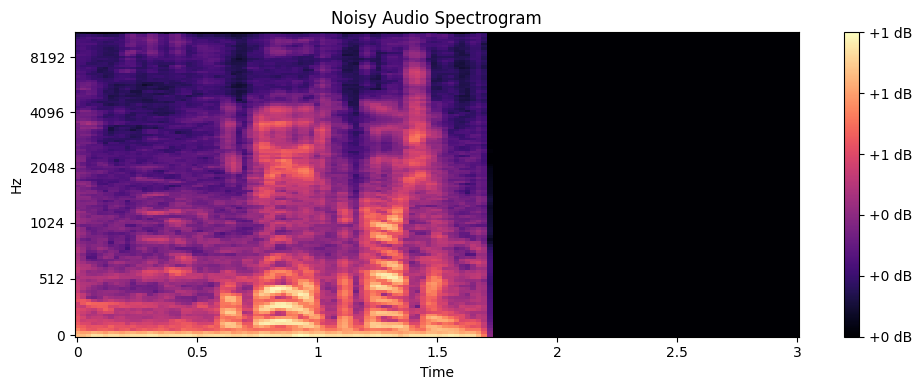

In [17]:
clean_files = sorted(glob.glob(os.path.join(clean_dir, '*.wav')))
noisy_files = sorted(glob.glob(os.path.join(noisy_dir, '*.wav')))

print(f"Found {len(clean_files)} clean files and {len(noisy_files)} noisy files.")

# For a paired training set, use the minimum number of files available
num_files = min(len(clean_files), len(noisy_files))
print(f"Using {num_files} paired files for training.")

# Preprocess files: compute Mel-spectrograms for autoencoder training
clean_specs = []
noisy_specs = []

for i in range(num_files):
    clean_spec = preprocess_file(clean_files[i])
    noisy_spec = preprocess_file(noisy_files[i])
    if clean_spec is not None and noisy_spec is not None:
        clean_specs.append(clean_spec)
        noisy_specs.append(noisy_spec)
        print(f"File {i+1} preprocessed successfully.")

clean_specs = np.array(clean_specs)   # Shape: (num_files, 1, n_mels, time_frames)
noisy_specs = np.array(noisy_specs)

print("Clean spectrograms shape:", clean_specs.shape)
print("Noisy spectrograms shape:", noisy_specs.shape)

# Visualize a random example from each set
idx = np.random.randint(1, num_files)
visualize_waveform(load_audio(clean_files[idx]), title="Clean Audio Waveform")
visualize_spectrogram(np.squeeze(compute_mel_spectrogram(load_audio(clean_files[idx]))), title="Clean Audio Spectrogram")
visualize_waveform(load_audio(noisy_files[idx]), title="Noisy Audio Waveform")
visualize_spectrogram(np.squeeze(compute_mel_spectrogram(load_audio(noisy_files[idx]))), title="Noisy Audio Spectrogram")

## Train-Test Split

In [18]:
X_train, X_val, y_train, y_val = train_test_split(
    noisy_specs, clean_specs, test_size=0.2, random_state=42
)
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)

Training set: (659, 1, 128, 128) (659, 1, 128, 128)
Validation set: (165, 1, 128, 128) (165, 1, 128, 128)


In [19]:
class AudioDataset(Dataset):
    def __init__(self, noisy_data, clean_data):
        self.noisy = torch.tensor(noisy_data, dtype=torch.float32)
        self.clean = torch.tensor(clean_data, dtype=torch.float32)
    
    def __len__(self):
        return len(self.noisy)
    
    def __getitem__(self, idx):
        return self.noisy[idx], self.clean[idx]

batch_size = 8
train_dataset = AudioDataset(X_train, y_train)
val_dataset = AudioDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

## Defining the model

In [20]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # (batch, 32, n_mels, time_frames)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0),         # (batch, 32, n_mels/2, time_frames/2)
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2, padding=0)          # (batch, 64, n_mels/4, time_frames/4)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()  # output normalized between [0,1]
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create model instance and move to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DenoisingAutoencoder().to(device)
print(model)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Upsample(scale_factor=2.0, mode='nearest')
    (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)


## Training the model

In [25]:
num_epochs = 50
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for noisy_batch, clean_batch in train_loader:
        noisy_batch = noisy_batch.to(device)
        clean_batch = clean_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(noisy_batch)
        loss = criterion(outputs, clean_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * noisy_batch.size(0)
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for noisy_batch, clean_batch in val_loader:
            noisy_batch = noisy_batch.to(device)
            clean_batch = clean_batch.to(device)
            outputs = model(noisy_batch)
            loss = criterion(outputs, clean_batch)
            val_running_loss += loss.item() * noisy_batch.size(0)
    epoch_val_loss = val_running_loss / len(val_dataset)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")

Epoch [1/50], Train Loss: 0.0068, Val Loss: 0.0064
Epoch [2/50], Train Loss: 0.0066, Val Loss: 0.0063
Epoch [3/50], Train Loss: 0.0066, Val Loss: 0.0065
Epoch [4/50], Train Loss: 0.0065, Val Loss: 0.0062
Epoch [5/50], Train Loss: 0.0063, Val Loss: 0.0084
Epoch [6/50], Train Loss: 0.0066, Val Loss: 0.0060
Epoch [7/50], Train Loss: 0.0062, Val Loss: 0.0061
Epoch [8/50], Train Loss: 0.0061, Val Loss: 0.0060
Epoch [9/50], Train Loss: 0.0061, Val Loss: 0.0059
Epoch [10/50], Train Loss: 0.0061, Val Loss: 0.0061
Epoch [11/50], Train Loss: 0.0059, Val Loss: 0.0058
Epoch [12/50], Train Loss: 0.0059, Val Loss: 0.0059
Epoch [13/50], Train Loss: 0.0060, Val Loss: 0.0064
Epoch [14/50], Train Loss: 0.0060, Val Loss: 0.0059
Epoch [15/50], Train Loss: 0.0058, Val Loss: 0.0056
Epoch [16/50], Train Loss: 0.0058, Val Loss: 0.0056
Epoch [17/50], Train Loss: 0.0057, Val Loss: 0.0056
Epoch [18/50], Train Loss: 0.0057, Val Loss: 0.0055
Epoch [19/50], Train Loss: 0.0057, Val Loss: 0.0056
Epoch [20/50], Train 

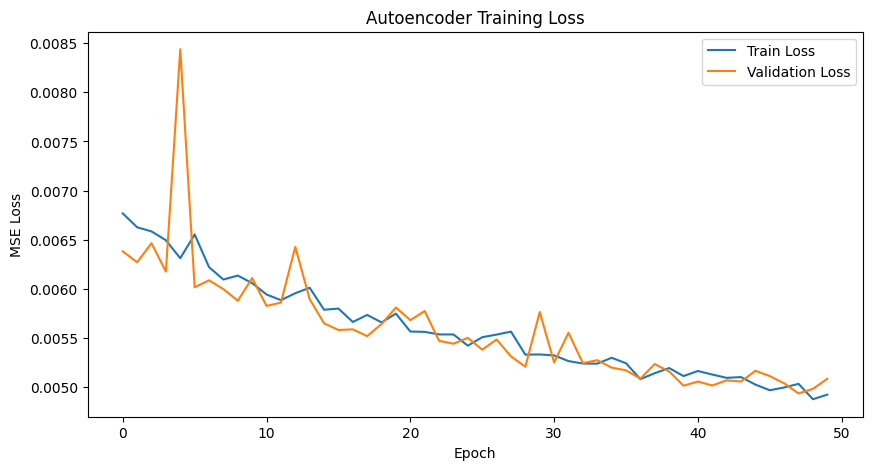

In [26]:
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


## Testing using an input

In [33]:
import numpy as np
import librosa
import librosa.display
import torch
import soundfile as sf
import matplotlib.pyplot as plt

def smooth_audio(y, window_len=101, window='hanning'):
    """
    Smooth a 1D array using convolution with a window.
    
    Parameters:
      - y: 1D numpy array (audio waveform)
      - window_len: Length of the smoothing window (should be an odd integer)
      - window: Type of window from ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
                'flat' will produce a moving average.
    Returns:
      - y_smooth: Smoothed 1D numpy array.
    """
    if y.ndim != 1:
        raise ValueError("smooth_audio only accepts 1D arrays.")
    if y.size < window_len:
        return y  # no smoothing if array is too short
    if window == 'flat':  # moving average
        w = np.ones(window_len)
    else:
        w = getattr(np, window)(window_len)
    # Normalize the window
    w /= w.sum()
    # Apply convolution; use mode 'same' for simplicity
    y_smooth = np.convolve(y, w, mode='same')
    return y_smooth

def denoise_audio_full(input_wav_path, output_wav_path, model, 
                       sr=SR, chunk_duration=DURATION, 
                       gain=50, n_iter=128, db_range=80, smooth_window=101):
    """
    Processes a long input audio file by splitting it into fixed-length segments 
    (chunk_duration seconds), denoising each segment with the model, and concatenating 
    the results. Applies a smoothing filter to the final waveform.
    
    Parameters:
      - input_wav_path: Path to the input (noisy) WAV file.
      - output_wav_path: Path to save the denoised output.
      - model: The trained autoencoder model.
      - sr: Sampling rate.
      - chunk_duration: Duration (in seconds) for each segment (should match training duration).
      - gain: Post-processing gain factor.
      - n_iter: Number of Griffin-Lim iterations.
      - db_range: Dynamic range used for normalization (e.g. 60 dB).
      - smooth_window: Window length for smoothing filter.
    """
    # Load full audio
    y_full, sr = librosa.load(input_wav_path, sr=sr)
    chunk_length = int(sr * chunk_duration)
    segments = []
    
    # Split audio into chunks (non-overlapping)
    for start in range(0, len(y_full), chunk_length):
        seg = y_full[start: start + chunk_length]
        # If the last segment is shorter than chunk_length, pad it with zeros
        if len(seg) < chunk_length:
            seg = np.pad(seg, (0, chunk_length - len(seg)), mode='constant')
        segments.append(seg)
    
    denoised_segments = []
    
    # Process each segment
    for seg in segments:
        # Compute Mel-spectrogram for the segment
        mel_spec = compute_mel_spectrogram(seg)
        # Crop or pad mel_spec to fixed TIME_FRAMES
        if mel_spec.shape[1] < TIME_FRAMES:
            pad_width = TIME_FRAMES - mel_spec.shape[1]
            mel_spec = np.pad(mel_spec, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mel_spec = mel_spec[:, :TIME_FRAMES]
        # Expand dims for (1, n_mels, TIME_FRAMES)
        mel_spec = np.expand_dims(mel_spec, axis=0)
        # Convert to tensor and add batch dimension: (1, 1, n_mels, TIME_FRAMES)
        input_tensor = torch.tensor(mel_spec, dtype=torch.float32).unsqueeze(0).to(device)
        
        # Run the autoencoder on the segment
        model.eval()
        with torch.no_grad():
            denoised_tensor = model(input_tensor)
        # Remove batch and channel dimensions -> shape: (n_mels, TIME_FRAMES)
        denoised_mel = denoised_tensor.squeeze().cpu().numpy()
        # Invert normalization: map from [0, 1] to [-db_range, 0] dB
        denoised_db = denoised_mel * db_range - db_range
        # Convert from dB to power (linear scale)
        denoised_power = librosa.db_to_power(denoised_db)
        
        # Reconstruct waveform using Griffin-Lim with increased iterations
        seg_denoised = librosa.feature.inverse.mel_to_audio(
            denoised_power, sr=sr, n_iter=n_iter, hop_length=HOP_LENGTH, n_fft=2048
        )
        # Apply gain adjustment and clip to avoid artifacts
        seg_denoised = seg_denoised * gain
        seg_denoised = np.clip(seg_denoised, -1.0, 1.0)
        
        denoised_segments.append(seg_denoised)
    
    # Concatenate all denoised segments
    y_denoised_full = np.concatenate(denoised_segments)
    
    # Apply smoothing filter to the final waveform
    y_denoised_full = smooth_audio(y_denoised_full, window_len=smooth_window, window='hanning')
    
    # Save the output audio file with explicit format/subtype
    sf.write(output_wav_path, y_denoised_full, sr, format='WAV', subtype='PCM_16')
    print(f"Denoised full audio saved to: {output_wav_path}")
    
    # Plot comparison for the first segment
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    librosa.display.waveshow(segments[0], sr=sr)
    plt.title("Noisy Segment (First Chunk)")
    plt.subplot(1, 2, 2)
    librosa.display.waveshow(denoised_segments[0], sr=sr)
    plt.title("Denoised Segment (First Chunk)")
    plt.tight_layout()
    plt.show()
    
    # Plot the full waveform comparison
    y_noisy_full, _ = librosa.load(input_wav_path, sr=sr)
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    librosa.display.waveshow(y_noisy_full, sr=sr)
    plt.title("Full Noisy Audio")
    plt.subplot(2, 1, 2)
    librosa.display.waveshow(y_denoised_full, sr=sr)
    plt.title("Full Denoised Audio (Smoothed)")
    plt.tight_layout()
    plt.show()


Denoised full audio saved to: ./output/noisy_sample.wav


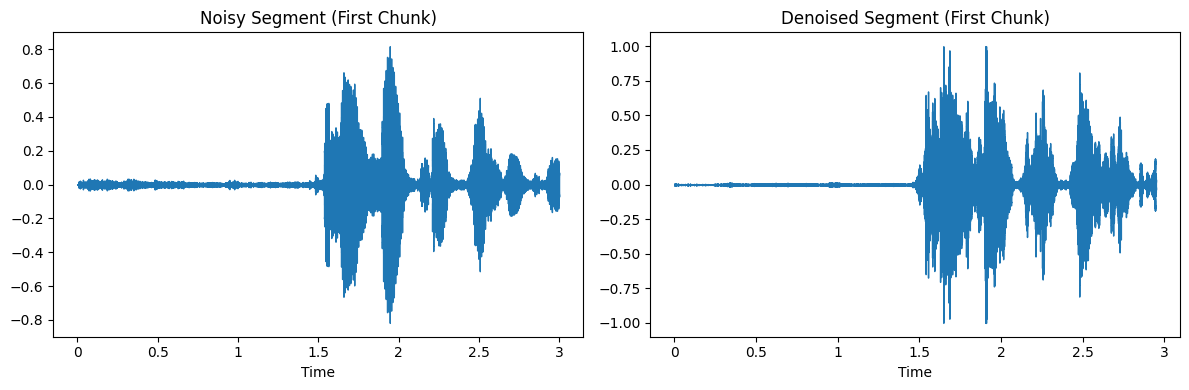

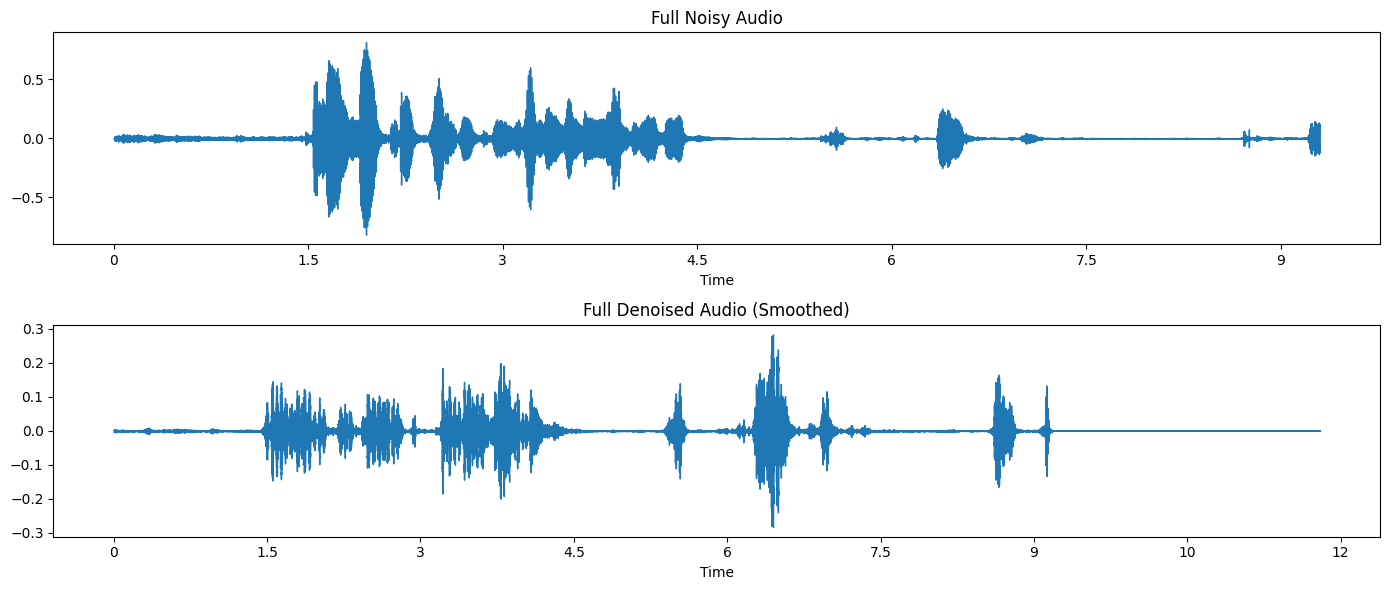

In [34]:
# Provide paths for a demonstration file (change these as needed)
filename='noisy_sample.wav'
demo_dir = 'output'
demo_noisy_path = f"./{filename}"
demo_output_path = f"./{demo_dir}/{filename}"

# Ensure the demo directory exists
os.makedirs(f"./{demo_dir}", exist_ok=True)

# Process the full long file
denoise_audio_full(demo_noisy_path, demo_output_path, model, sr=SR, chunk_duration=3, gain=50, n_iter=64)
